# Going Deeper NLP Project 4. Vocabulary Size를 변경해서 뉴스 카테고리를 다중 분류하기

## 📍 About Project
- `Reuters` 뉴스 데이터셋을 이용하여 해당 뉴스가 어느 카테고리에 속하는지를 예측
- 단어의 수에 따라 모델의 성능이 어떻게 변화하는지 테스트
- `num_words`로 사용할 단어의 수를 조정
  - 빈도수가 많은 순서대로 나열했을 때, `num_words`의 인자로 준 정숫값만큼의 단어를 사용
  - 나머지 단어는 전부 `<unk>`로 처리하는 원리
  - 변화된 단어 수에 따른 모델의 성능을 최소 3가지 이상의 케이스로 실험
  - 사용할 모델
    - 나이브 베이즈 분류기
    - CNB
    - 로지스틱 회귀
    - 서포트 벡터 머신
    - 결정 트리
    - 랜덤 포레스트 
    - 그래디언트 부스팅 트리
    - 보팅

## 🎯 Rubric
1. 분류 모델의 `accuracy`가 기준 이상 높게 나왔는가?<br>
3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.<br>
2. 분류 모델의 `F1 score`가 기준 이상 높게 나왔는가?<br>
`Vocabulary size`에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.<br>
3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?<br>
동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.

In [3]:
# 실습에 필요한 디렉터리 생성
! mkdir -p ~/aiffel/reuters_classifiaction

In [4]:
from tensorflow.keras.datasets import reuters   # 로이터 뉴스 데이터 로드
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [5]:
# 훈련 데이터와 테스트 데이터 로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

2113536/2110848 [==============================] - 1s 0us/step


* `num_words`
  * 데이터에서 빈도수 기준으로 상위 몇 번째 단어까지 사용할 것인지 조절
  * 각 단어는 고유한 번호가 정해져 있는 상태이고, 이를 통해서 사용할 단어의 수를 결정
  * 해당 데이터셋의 단어들은 등장 빈도의 수가 높은 순서대로 낮은 정수가 맵핑되어 있음
  * 코드에서 `num_words=10000`은 1~10000번 단어만 사용함을 의미
* 주의
  * `num_words`의 인자로 10,000을 기재한다고 해서 10,000보다 높은 정수가 맵핑된 단어들이 받아온 데이터에서 사라지지 않음
  * 주어진 값보다 큰 번호를 가졌던 단어들은 특정 번호로 전부 맵핑
  * OOV 문제


In [6]:
# 데이터 구성 출력
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [7]:
# 데이터의 숫자 시퀀스 출력
print(x_train[0])
print(x_test[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]


* 이미 뉴스 데이터를 다운로드할 때 단어가 아닌 해당 번호로 변환되어 출력됨
* 대부분의 자연어 처리에서는 텍스트를 숫자로 수치화하는 과정 필요
* Tensorflow 데이터셋에서는 이미 전처리가 진행된 데이터를 제공

In [8]:
# label 출력
print(y_train[0])
print(y_test[0])

3
3


In [9]:
# 현재 클래스의 개수 확인
# 숫자 0부터 시작되는 레이블로, 모든 레이블 중 최대값을 구하고 1을 더하는 방식
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


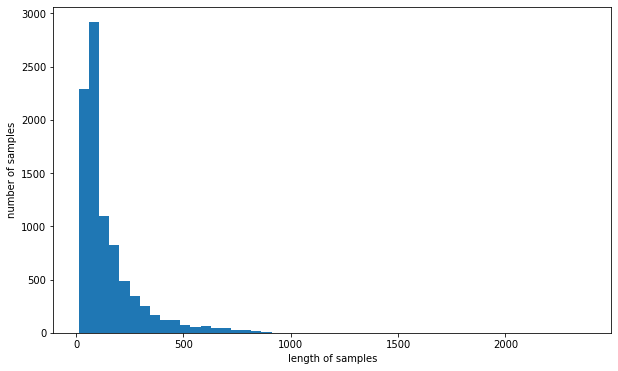

In [10]:
# 뉴스 데이터의 분포 시각화

print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.figure(figsize=(10,6))
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

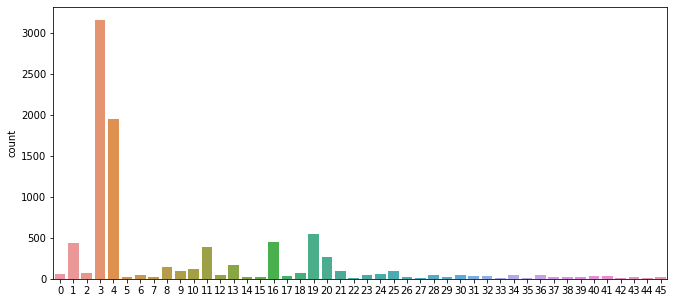

In [11]:
# 클래스 분포 시각화
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

* 해당 뉴스 데이터는 3, 4번 클래스가 대부분을 차지함

In [12]:
# 각 클래스의 빈도 수 출력
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [13]:
# 원본(텍스트 형태) 뉴스 데이터로 변환
word_index = reuters.get_word_index(path="reuters_word_index.json")
# 로이터 뉴스 데이터는 '단어'를 key값으로, 고유한 '정수'를 value로 가지는 dictionary를 제공
print('=3')

557056/550378 [==============================] - 0s 0us/step
=3


In [14]:
print("word_index['the'] : ", word_index['the'])
print("word_index['it'] : ", word_index['it'])
print("word_index['they'] : ", word_index['they'])
print("word_index['i'] : ", word_index['i'])
print("word_index['you'] : ", word_index['you'])

word_index['the'] :  1
word_index['it'] :  13
word_index['they'] :  74
word_index['i'] :  265
word_index['you'] :  1025


* 현재의 정수 시퀀스 데이터를 텍스트 형태로 되돌려야 하므로, 정수로부터 단어를 얻을 수 있는 `index_word`가 필요
* `word_index`에 입력했을 떄 얻는 숫자에서 3을 더한 숫자가 본래 고유한 숫자

In [15]:
index_to_word = { index+3 : word for word, index in word_index.items() }
print('=3')

=3


In [16]:
print("index_to_word[4] : ", index_to_word[4])
print("index_to_word[16] : ", index_to_word[16])
print("index_to_word[77] : ", index_to_word[77])
print("index_to_word[268] : ", index_to_word[268])
print("index_to_word[1028] : ", index_to_word[1028])

index_to_word[4] :  the
index_to_word[16] :  it
index_to_word[77] :  they
index_to_word[268] :  i
index_to_word[1028] :  you


* 0번, 1번, 2번은 각각 `<pad>`, `<sos>`, `<unk>`라는 자연어 처리를 위한 특별한 토큰들을 위해 맵핑된 번호
* 만들어진 `index_to_word`에 추가적으로 해당 작업을 해 주어야 함

In [17]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token
print('=3')

=3


In [18]:
# index_to_word를 통해서 첫 번째 훈련용 뉴스 기사를 원래 텍스트로 복원
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


* OOV(Out-Of-Vocabulary) 문제
  * 기계가 미처 배우지 못한 모르는 단어
  * 어떤 단어를 기계가 모르는 단어로 판단하면, 기계는 해당 단어를 전부 `<unk>`라는 일관된 특별 토큰으로 변환

In [19]:
# index_word를 사용하여 [4, 587, 23, 133, 6, 30, 515]인 정수 시퀀스를 텍스트 시퀀스로 변환
print(' '.join([index_to_word[index] for index in [4, 587, 23, 133, 6, 30, 515]]))

the transaction is expected to be completed


In [20]:
# [4, 12000, 23, 133, 6, 30, 515]인 정수 시퀀스의 문장 출력
print(' '.join([index_to_word[index] for index in [4, 12000, 23, 133, 6, 30, 515]]))

the staffing is expected to be completed


* 해당 정수 시퀀스는 `[4, 2, 23, 133, 6, 30, 515]`
* 12,000은 10,000을 넘는 숫자로 OOV에 해당되므로 `<unk>`인 2로 변환되어 데이터가 로드

In [21]:
# 전체 훈련용 뉴스 데이터와 전체 테스트용 뉴스 데이터를 텍스트 데이터로 변환
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [22]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


In [23]:
# 각각 5개씩 출력 해 보고, 제대로 변환이 되었는지 확인
print(x_train[:5])
print(x_test[:5])

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3', '<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3', '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for one

In [24]:
# 사이킷런의 CountVectorizer를 이용하여 DTM 생성 후 DTM의 크기 확인
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 9670)


In [25]:
# TfidfTransformer를 이용하여 TF-IDF 행렬 생성
# TF-IDF Matrix는 추가적인 전처리를 하지 않는 이상, DTM과 동일한 크기를 가짐
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 9670)


In [26]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

* 나이브 베이즈 분류기
* CNB(Complement Naive Bayes)
* 로지스틱 회귀(Logistic Regression)
* 선형 서포트 벡터 머신(Linear Support Vector Machine)
* 결정 트리(Decision Tree)
* 랜덤 포레스트(Random Forest)
* 그래디언트 부스팅 트리(GradientBoostingClassifier)
* 보팅(Voting)

In [27]:
def train_ml(tfidfv, y_train, tfidfv_test, y_test):
    # 나이브 베이즈 분류기 
    mod = MultinomialNB()
    mod.fit(tfidfv, y_train)
    # fit() 함수를 이용하여 훈련 데이터와 해당 훈련 데이터에 대한 레이블을 인자로 사용하여 모델이 이를 학습하도록 함
    
    # 테스트 데이터에 대한 정확도를 측정하기 위해 훈련 데이터와 동일한 전처리 수행 필요 - TF-IDF 변환
    mod_predicted = mod.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("나이브 베이즈 정확도:", accuracy_score(y_test, mod_predicted)) #예측값과 실제값 비교를 통한 정확도 측정
    # 정밀도, 재현율, F1 Score 측정
    print(classification_report(y_test, mod.predict(tfidfv_test), zero_division=0))

    # CNB(Complement Naive Bayes)
    cb = ComplementNB()
    cb.fit(tfidfv, y_train)
    
    cb_predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("CNB 정확도:", accuracy_score(y_test, cb_predicted)) #예측값과 실제값 비교
    print(classification_report(y_test, cb.predict(tfidfv_test), zero_division=0))
    
    # 로지스틱 회귀 
    lr = LogisticRegression(C=10000, penalty='l2')
    lr.fit(tfidfv, y_train)

    lr_predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("로지스틱 회귀 정확도:", accuracy_score(y_test, lr_predicted)) #예측값과 실제값 비교
    print(classification_report(y_test, lr.predict(tfidfv_test), zero_division=0))
    
    # 선형 서포트 벡터 머신 
    lsvc = LinearSVC(C=10000, penalty='l1', max_iter=500, dual=False)
    lsvc.fit(tfidfv, y_train)
    
    lsvc_predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("SVM 정확도:", accuracy_score(y_test, lsvc_predicted)) #예측값과 실제값 비교
    print(classification_report(y_test, lsvc.predict(tfidfv_test), zero_division=0))

    # 결정 트리(Decision Tree) 
    tree = DecisionTreeClassifier(max_depth=10, random_state=0)
    tree.fit(tfidfv, y_train)
    
    tree_predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("결정 트리 정확도:", accuracy_score(y_test, tree_predicted)) #예측값과 실제값 비교
    print(classification_report(y_test, tree.predict(tfidfv_test), zero_division=0))

    # 랜덤 포레스트(Random Forest)
    forest = RandomForestClassifier(n_estimators=5, random_state=0)
    forest.fit(tfidfv, y_train)
    
    forest_predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("랜덤 포레스트 정확도:", accuracy_score(y_test, forest_predicted)) #예측값과 실제값 비교
    print(classification_report(y_test, forest.predict(tfidfv_test), zero_division=0))
    
    # 그래디언트 부스팅 트리(GradientBoostingClassifier)
    grbt = GradientBoostingClassifier(random_state=0, verbose=3) # verbose=3
    grbt.fit(tfidfv, y_train)

    grbt_predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("그래디언트 부스팅 트리 정확도:", accuracy_score(y_test, grbt_predicted)) #예측값과 실제값 비교
    print(classification_report(y_test, grbt.predict(tfidfv_test), zero_division=0))

    # 보팅(Voting)
    voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
        ], voting='soft', n_jobs=-1)
    voting_classifier.fit(tfidfv, y_train)
    
    voting_classifier_predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print("보팅 정확도:", accuracy_score(y_test, voting_classifier_predicted)) #예측값과 실제값 비교
    print(classification_report(y_test, voting_classifier.predict(tfidfv_test), zero_division=0))

    return mod, cb, lr, lsvc, tree, forest, grbt, voting_classifier

In [28]:
import time
import datetime

start = time.time() 

mod, cb, lr, lsvc, tree, forest, grbt, voting_classifier = train_ml(tfidfv, y_train, tfidfv_test, y_test)

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('run time :', times)

나이브 베이즈 정확도: 0.6567230632235085
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.69      0.65       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.63      0.64        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.69      0.56      0.61      

SVM 정확도: 0.7123775601068566
              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.58      0.60      0.59       105
           2       0.70      0.35      0.47        20
           3       0.89      0.89      0.89       813
           4       0.80      0.82      0.81       474
           5       0.00      0.00      0.00         5
           6       0.79      0.79      0.79        14
           7       0.33      0.33      0.33         3
           8       0.42      0.55      0.48        38
           9       0.61      0.68      0.64        25
          10       0.56      0.73      0.64        30
          11       0.56      0.66      0.61        83
          12       0.18      0.23      0.20        13
          13       0.44      0.43      0.44        37
          14       0.00      0.00      0.00         2
          15       0.50      0.22      0.31         9
          16       0.50      0.61      0.55        99

         1           1.4608           11.00m
         2       95544.1548           11.16m
         3      105411.1055           11.28m
         4 26490374809120059619893320924222374741943986946048.0000           11.47m
         5 3332464259228453694671945105465820387521328203545526380221295913764842145866429631276902168311601749602693928777633481065758720.0000           11.74m
         6 3332464259228453694671945105465820387521328203545526380221295913764842145866429631276902168311601749602693928777633481065758720.0000           11.48m
         7 3332464259228453694671945105465820387521328203545526380221295913764842145866429631276902168311601749602693928777633481065758720.0000           11.26m
         8 3332464259228453694671945105465820387521328203545526380221295913764842145866429631276902168311601749602693928777633481065758720.0000           11.09m
         9 333246425922845369467194510546582038752132820354552638022129591376484214586642963127690216831160174960269392877763348106575872

        55 14834291270935598097793813192422686817633454293445808551806972586635235618984506254543094943361504759490214512223227966451089408.0000            5.34m
        56 14834291270935598097793813192422686817633454293445808551806972586635235618984506254543094943361504759490214512223227966451089408.0000            5.22m
        57 14834291270935598097793813192422686817633454293445808551806972586635235618984506254543094943361504759490214512223227966451089408.0000            5.11m
        58 14834291270935598097793813192422686817633454293445808551806972586635235618984506254543094943361504759490214512223227966451089408.0000            4.99m
        59 14834291270935598097793813192422686817633454293445808551806972586635235618984506254543094943361504759490214512223227966451089408.0000            4.87m
        60 14834291270935598097793813192422686817633454293445808551806972586635235618984506254543094943361504759490214512223227966451089408.0000            4.75m
        61 14834291270935598

/Users/sallyride/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


보팅 정확도: 0.8116651825467498
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.77      0.74      0.76       105
           2       0.73      0.80      0.76        20
           3       0.92      0.94      0.93       813
           4       0.83      0.88      0.85       474
           5       1.00      0.20      0.33         5
           6       0.86      0.86      0.86        14
           7       1.00      0.67      0.80         3
           8       0.70      0.68      0.69        38
           9       0.81      0.84      0.82        25
          10       0.93      0.90      0.92        30
          11       0.65      0.69      0.67        83
          12       0.46      0.46      0.46        13
          13       0.68      0.62      0.65        37
          14       0.14      0.50      0.22         2
          15       0.57      0.44      0.50         9
          16       0.72      0.75      0.73        99


In [29]:
x_test[3] # 네 번째 샘플의 원문 출력

'<sos> <unk> <unk> oil and gas partnership said it completed the sale of interests in two major oil and gas fields to lt energy assets international corp for 21 mln dlrs the company said it sold about one half of its 50 pct interest in the oak hill and north <unk> fields its two largest producing properties it said it used about 20 mln dlrs of the proceeds to <unk> principal on its senior secured notes semi annual principal payments on the remaining 40 mln dlrs of notes have been satisfied until december 1988 as a result it said the company said the note agreements were amended to reflect an easing of some financial covenants and an increase of interest to 13 5 pct from 13 0 pct until december 1990 it said the <unk> exercise price for 1 125 000 warrants was also reduced to 50 cts from 1 50 dlrs the company said energy assets agreed to share the costs of increasing production at the oak hill field reuter 3'

In [30]:
y_test[3] # 해당 샘플의 레이블 출력

4

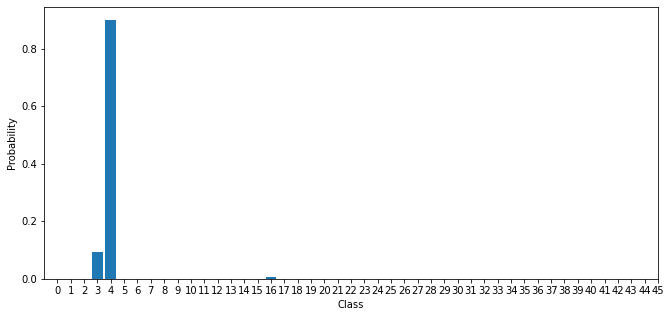

In [31]:
# 모델이 결정한 확률을 그래프로 시각화
probability = mod.predict_proba(tfidfv_test[3])[0]

plt.rcParams["figure.figsize"] = (11,5)
plt.bar(mod.classes_, probability)
plt.xlim(-1, 21)
plt.xticks(mod.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [32]:
mod.predict(tfidfv_test[3])

array([4])

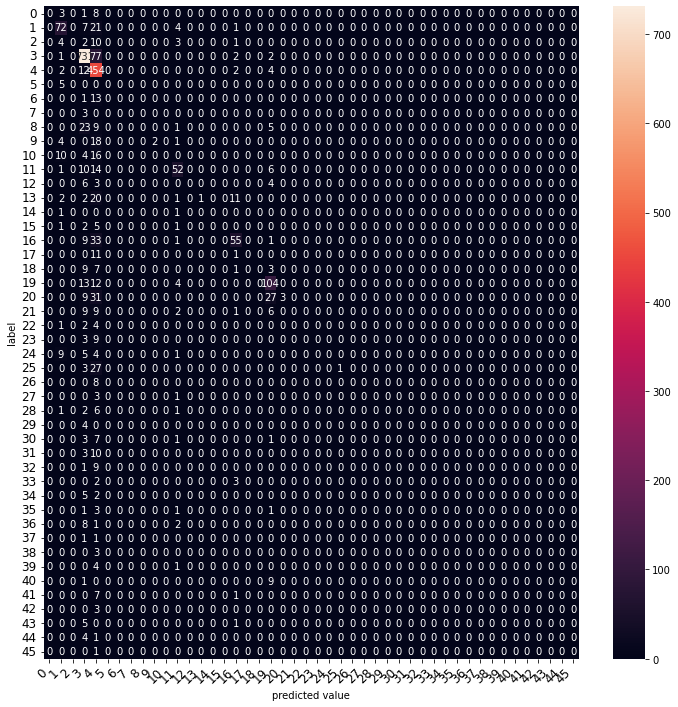

In [33]:
# 혼동 행렬(confusion matrix) 시각화
def graph_confusion_matrix(mod, x_test, y_test):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, mod.predict(x_test)))
  #, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(12,12))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

graph_confusion_matrix(mod, tfidfv_test, y_test)

## Vocabulary Size를 변경해서 시도 해 보기

In [34]:
(x_train_n, y_train_n), (x_test_n, y_test_n) = reuters.load_data(num_words=None, test_split=0.2)
(x_train_5k, y_train_5k), (x_test_5k, y_test_5k) = reuters.load_data(num_words=5000, test_split=0.2)
(x_train_15k, y_train_15k), (x_test_15k, y_test_15k) = reuters.load_data(num_words=15000, test_split=0.2)
(x_train_20k, y_train_20k), (x_test_20k, y_test_20k) = reuters.load_data(num_words=20000, test_split=0.2)

In [35]:
print('모든 단어 사용 시 훈련 샘플의 수: {}'.format(len(x_train_n)))
print('모든 단어 사용 시 테스트 샘플의 수: {}'.format(len(x_test_n)))
print('5000 단어 사용 시 훈련 샘플의 수: {}'.format(len(x_train_5k)))
print('5000 단어 사용 시 테스트 샘플의 수: {}'.format(len(x_test_5k)))
print('15000 단어 사용 시 훈련 샘플의 수: {}'.format(len(x_train_15k)))
print('15000 단어 사용 시 테스트 샘플의 수: {}'.format(len(x_test_15k)))
print('20000 단어 사용 시 훈련 샘플의 수: {}'.format(len(x_train_20k)))
print('20000 단어 사용 시 테스트 샘플의 수: {}'.format(len(x_test_20k)))

모든 단어 사용 시 훈련 샘플의 수: 8982
모든 단어 사용 시 테스트 샘플의 수: 2246
5000 단어 사용 시 훈련 샘플의 수: 8982
5000 단어 사용 시 테스트 샘플의 수: 2246
15000 단어 사용 시 훈련 샘플의 수: 8982
15000 단어 사용 시 테스트 샘플의 수: 2246
20000 단어 사용 시 훈련 샘플의 수: 8982
20000 단어 사용 시 테스트 샘플의 수: 2246


In [36]:
print("모든 단어 사용 시 데이터의 숫자 시퀀스와 라벨")
print(x_train_n[0])
print(x_test_n[0])
print(y_train_n[0])
print(y_test_n[0])
print("----------------------------------")
print("5000 단어 사용 시 데이터의 숫자 시퀀스와 라벨")
print(x_train_5k[0])
print(x_test_5k[0])
print(y_train_5k[0])
print(y_test_5k[0])
print("----------------------------------")
print("15000 단어 사용 시 데이터의 숫자 시퀀스와 라벨")
print(x_train_15k[0])
print(x_test_15k[0])
print(y_train_15k[0])
print(y_test_15k[0])
print("----------------------------------")
print("15000 단어 사용 시 데이터의 숫자 시퀀스와 라벨")
print(x_train_20k[0])
print(x_test_20k[0])
print(y_train_20k[0])
print(y_test_20k[0])

모든 단어 사용 시 데이터의 숫자 시퀀스와 라벨
[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27

In [37]:
num_classes_n = max(y_train_n) + 1
print('모든 단어 사용 시 클래스의 수 : {}'.format(num_classes_n))
num_classes_5k = max(y_train_5k) + 1
print('5000 단어 사용 시 클래스의 수 : {}'.format(num_classes_5k))
num_classes_15k = max(y_train_15k) + 1
print('15000 단어 사용 시 클래스의 수 : {}'.format(num_classes_15k))
num_classes_20k = max(y_train_20k) + 1
print('20000 단어 사용 시 클래스의 수 : {}'.format(num_classes_20k))

모든 단어 사용 시 클래스의 수 : 46
5000 단어 사용 시 클래스의 수 : 46
15000 단어 사용 시 클래스의 수 : 46
20000 단어 사용 시 클래스의 수 : 46


모든 단어 사용 시 훈련용 뉴스의 최대 길이 :2376
모든 단어 사용 시 훈련용 뉴스의 평균 길이 :145.5398574927633
----------------------------------
5000 단어 사용 시 훈련용 뉴스의 최대 길이 :2376
5000 단어 사용 시 훈련용 뉴스의 평균 길이 :145.5398574927633
----------------------------------
15000 단어 사용 시 훈련용 뉴스의 최대 길이 :2376
15000 단어 사용 시 훈련용 뉴스의 평균 길이 :145.5398574927633
----------------------------------
20000 단어 사용 시 훈련용 뉴스의 최대 길이 :2376
20000 단어 사용 시 훈련용 뉴스의 평균 길이 :145.5398574927633


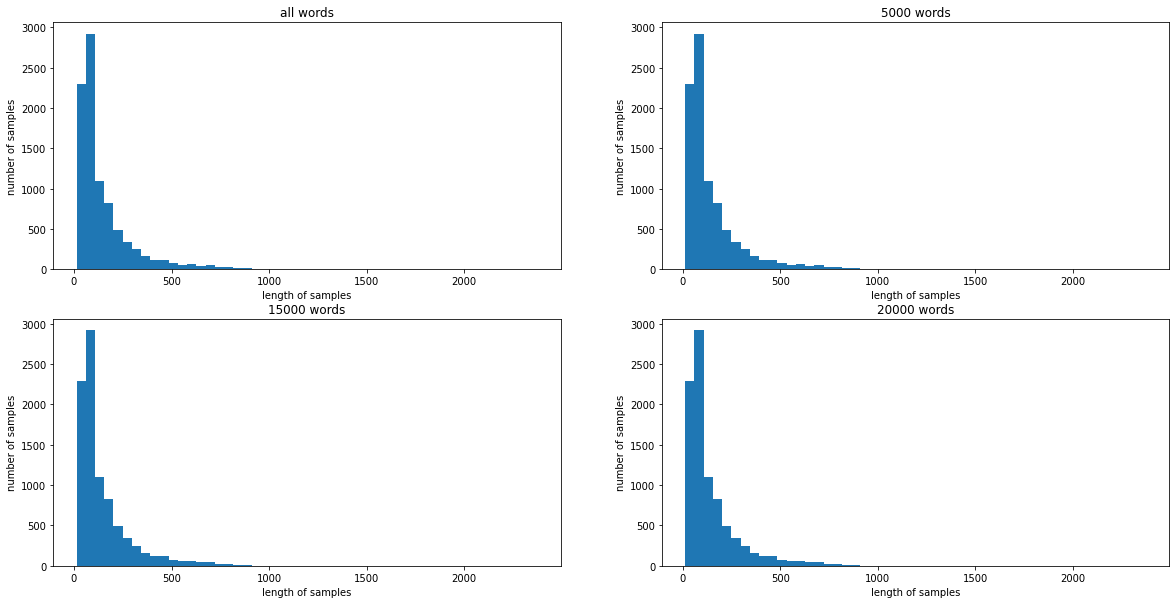

In [38]:
print('모든 단어 사용 시 훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train_n)))
print('모든 단어 사용 시 훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train_n))/len(x_train_n)))
print("----------------------------------")
print('5000 단어 사용 시 훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train_5k)))
print('5000 단어 사용 시 훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train_5k))/len(x_train_5k)))
print("----------------------------------")
print('15000 단어 사용 시 훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train_15k)))
print('15000 단어 사용 시 훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train_15k))/len(x_train_15k)))
print("----------------------------------")
print('20000 단어 사용 시 훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train_20k)))
print('20000 단어 사용 시 훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train_20k))/len(x_train_20k)))

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.title('all words')
plt.hist([len(s) for s in x_train_n], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.subplot(2,2,2)
plt.title('5000 words')
plt.hist([len(s) for s in x_train_5k], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.subplot(2,2,3)
plt.title('15000 words')
plt.hist([len(s) for s in x_train_15k], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.subplot(2,2,4)
plt.title('20000 words')
plt.hist([len(s) for s in x_train_20k], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

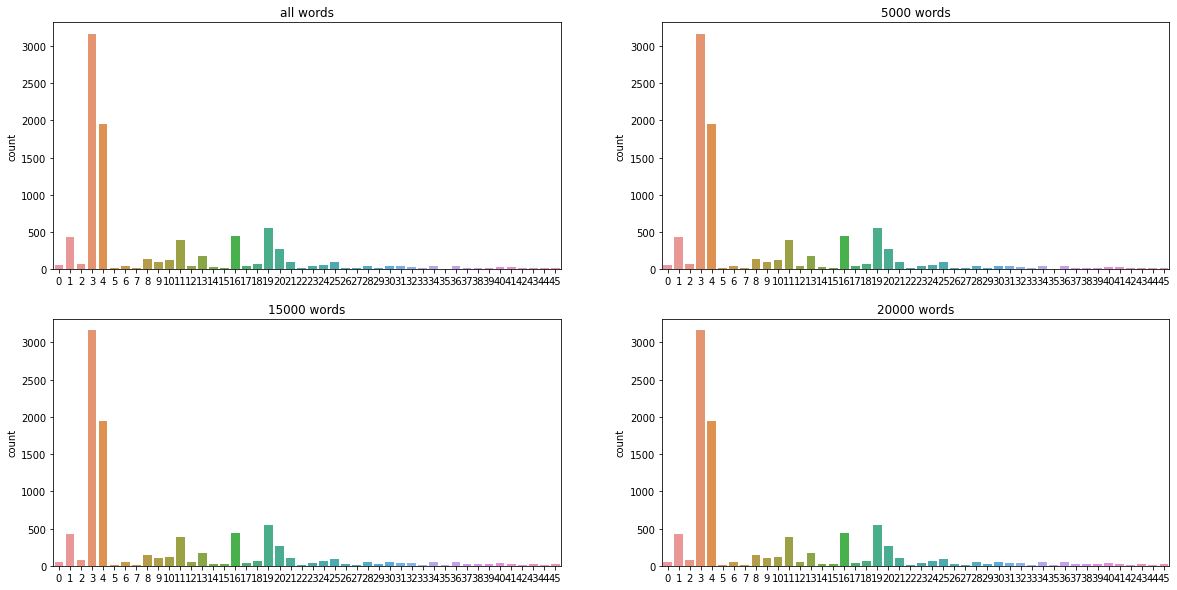

In [39]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.countplot(x = y_train_n)
plt.title('all words')
plt.subplot(2,2,2)
sns.countplot(x = y_train_5k)
plt.title('5000 words')
plt.subplot(2,2,3)
sns.countplot(x = y_train_15k)
plt.title('15000 words')
plt.subplot(2,2,4)
sns.countplot(x = y_train_20k)
plt.title('20000 words')
plt.show()

In [40]:
unique_elements_n, counts_elements_n = np.unique(y_train_n, return_counts = True)
print("모든 단어 사용 시 각 클래스 빈도수:")
print(np.asarray((unique_elements_n, counts_elements_n)))
unique_elements_5k, counts_elements_5k = np.unique(y_train_5k, return_counts = True)
print("5000 단어 사용 시 각 클래스 빈도수:")
print(np.asarray((unique_elements_5k, counts_elements_5k)))
unique_elements_15k, counts_elements_15k = np.unique(y_train_15k, return_counts = True)
print("15000 단어 사용 시 각 클래스 빈도수:")
print(np.asarray((unique_elements_15k, counts_elements_15k)))
unique_elements_20k, counts_elements_20k = np.unique(y_train_20k, return_counts = True)
print("20000 단어 사용 시 각 클래스 빈도수:")
print(np.asarray((unique_elements_20k, counts_elements_20k)))

모든 단어 사용 시 각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]
5000 단어 사용 시 각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   1

In [41]:
word_index_n = reuters.get_word_index(path="reuters_word_index.json")
word_index_5k = reuters.get_word_index(path="reuters_word_index.json")
word_index_15k = reuters.get_word_index(path="reuters_word_index.json")
word_index_20k = reuters.get_word_index(path="reuters_word_index.json")

In [42]:
print("모든 단어 사용 시 ")
print("word_index_n['the'] : ", word_index_n['the'])
print("word_index_n['it'] : ", word_index_n['it'])
print("word_index_n['they'] : ", word_index_n['they'])
print("word_index_n['i'] : ", word_index_n['i'])
print("word_index_n['you'] : ", word_index_n['you'])
print("----------------------------------")
print("5000 단어 사용 시 ")
print("word_index_5k['the'] : ", word_index_5k['the'])
print("word_index_5k['it'] : ", word_index_5k['it'])
print("word_index_5k['they'] : ", word_index_5k['they'])
print("word_index_5k['i'] : ", word_index_5k['i'])
print("word_index_5k['you'] : ", word_index_5k['you'])
print("----------------------------------")
print("15000 단어 사용 시 ")
print("word_index_15k['the'] : ", word_index_15k['the'])
print("word_index_15k['it'] : ", word_index_15k['it'])
print("word_index_15k['they'] : ", word_index_15k['they'])
print("word_index_15k['i'] : ", word_index_15k['i'])
print("word_index_15k['you'] : ", word_index_15k['you'])
print("----------------------------------")
print("20000 단어 사용 시 ")
print("word_index_20k['the'] : ", word_index_20k['the'])
print("word_index_20k['it'] : ", word_index_20k['it'])
print("word_index_20k['they'] : ", word_index_20k['they'])
print("word_index_20k['i'] : ", word_index_20k['i'])
print("word_index_20k['you'] : ", word_index_20k['you'])
print("----------------------------------")

모든 단어 사용 시 
word_index_n['the'] :  1
word_index_n['it'] :  13
word_index_n['they'] :  74
word_index_n['i'] :  265
word_index_n['you'] :  1025
----------------------------------
5000 단어 사용 시 
word_index_5k['the'] :  1
word_index_5k['it'] :  13
word_index_5k['they'] :  74
word_index_5k['i'] :  265
word_index_5k['you'] :  1025
----------------------------------
15000 단어 사용 시 
word_index_15k['the'] :  1
word_index_15k['it'] :  13
word_index_15k['they'] :  74
word_index_15k['i'] :  265
word_index_15k['you'] :  1025
----------------------------------
20000 단어 사용 시 
word_index_20k['the'] :  1
word_index_20k['it'] :  13
word_index_20k['they'] :  74
word_index_20k['i'] :  265
word_index_20k['you'] :  1025
----------------------------------


In [43]:
index_to_word_n = { index+3 : word for word, index in word_index_n.items() }
index_to_word_5k = { index+3 : word for word, index in word_index_5k.items() }
index_to_word_15k = { index+3 : word for word, index in word_index_15k.items() }
index_to_word_20k = { index+3 : word for word, index in word_index_20k.items() }

In [44]:
print("모든 단어 사용 시 ")
print('index_to_word_n[4] : ', index_to_word_n[4])
print('index_to_word_n[16] : ', index_to_word_n[16])
print('index_to_word_n[77] : ', index_to_word_n[77])
print('index_to_word_n[268] : ', index_to_word_n[268])
print('index_to_word_n[1028] : ', index_to_word_n[1028])
print("----------------------------------")
print("5000 단어 사용 시 ")
print('index_to_word_5k[4] : ', index_to_word_5k[4])
print('index_to_word_5k[16] : ', index_to_word_5k[16])
print('index_to_word_5k[77] : ', index_to_word_5k[77])
print('index_to_word_5k[268] : ', index_to_word_5k[268])
print('index_to_word_5k[1028] : ', index_to_word_5k[1028])
print("----------------------------------")
print("15000 단어 사용 시 ")
print('index_to_word_15k[4] : ', index_to_word_15k[4])
print('index_to_word_15k[16] : ', index_to_word_15k[16])
print('index_to_word_15k[77] : ', index_to_word_15k[77])
print('index_to_word_15k[268] : ', index_to_word_15k[268])
print('index_to_word_15k[1028] : ', index_to_word_15k[1028])
print("----------------------------------")
print("20000 단어 사용 시 ")
print('index_to_word_20k[4] : ', index_to_word_20k[4])
print('index_to_word_20k[16] : ', index_to_word_20k[16])
print('index_to_word_20k[77] : ', index_to_word_20k[77])
print('index_to_word_20k[268] : ', index_to_word_20k[268])
print('index_to_word_20k[1028] : ', index_to_word_20k[1028])
print("----------------------------------")

모든 단어 사용 시 
index_to_word_n[4] :  the
index_to_word_n[16] :  it
index_to_word_n[77] :  they
index_to_word_n[268] :  i
index_to_word_n[1028] :  you
----------------------------------
5000 단어 사용 시 
index_to_word_5k[4] :  the
index_to_word_5k[16] :  it
index_to_word_5k[77] :  they
index_to_word_5k[268] :  i
index_to_word_5k[1028] :  you
----------------------------------
15000 단어 사용 시 
index_to_word_15k[4] :  the
index_to_word_15k[16] :  it
index_to_word_15k[77] :  they
index_to_word_15k[268] :  i
index_to_word_15k[1028] :  you
----------------------------------
20000 단어 사용 시 
index_to_word_20k[4] :  the
index_to_word_20k[16] :  it
index_to_word_20k[77] :  they
index_to_word_20k[268] :  i
index_to_word_20k[1028] :  you
----------------------------------


In [45]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word_n[index]=token
  index_to_word_5k[index]=token
  index_to_word_15k[index]=token
  index_to_word_20k[index]=token
print('=3')

=3


In [46]:
print("모든 단어 사용 시 ")
print(' '.join([index_to_word_n[index] for index in x_train_n[0]]))
print("----------------------------------")
print("5000 단어 사용 시 ")
print(' '.join([index_to_word_5k[index] for index in x_train_5k[0]]))
print("----------------------------------")
print("15000 단어 사용 시 ")
print(' '.join([index_to_word_15k[index] for index in x_train_15k[0]]))
print("----------------------------------")
print("20000 단어 사용 시 ")
print(' '.join([index_to_word_20k[index] for index in x_train_20k[0]]))
print("----------------------------------")

모든 단어 사용 시 
<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
----------------------------------
5000 단어 사용 시 
<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
----------------------------------
15000 단어 사용 시 
<sos> <unk> <unk> said as a result of its december acquisition of space co it ex

In [47]:
print("모든 단어 사용 시 ")
print(' '.join([index_to_word_n[index] for index in [4, 587, 23, 133, 6, 30, 515]]))
print(' '.join([index_to_word_n[index] for index in [4, 12000, 23, 133, 6, 30, 515]]))
print("----------------------------------")
print("5000 단어 사용 시 ")
print(' '.join([index_to_word_5k[index] for index in [4, 587, 23, 133, 6, 30, 515]]))
print(' '.join([index_to_word_5k[index] for index in [4, 12000, 23, 133, 6, 30, 515]]))
print("----------------------------------")
print("15000 단어 사용 시 ")
print(' '.join([index_to_word_15k[index] for index in [4, 587, 23, 133, 6, 30, 515]]))
print(' '.join([index_to_word_15k[index] for index in [4, 12000, 23, 133, 6, 30, 515]]))
print("----------------------------------")
print("20000 단어 사용 시 ")
print(' '.join([index_to_word_20k[index] for index in [4, 587, 23, 133, 6, 30, 515]]))
print(' '.join([index_to_word_20k[index] for index in [4, 12000, 23, 133, 6, 30, 515]]))
print("----------------------------------")

모든 단어 사용 시 
the transaction is expected to be completed
the staffing is expected to be completed
----------------------------------
5000 단어 사용 시 
the transaction is expected to be completed
the staffing is expected to be completed
----------------------------------
15000 단어 사용 시 
the transaction is expected to be completed
the staffing is expected to be completed
----------------------------------
20000 단어 사용 시 
the transaction is expected to be completed
the staffing is expected to be completed
----------------------------------


In [48]:
decoded = []
for i in range(len(x_train_n)):
    t = ' '.join([index_to_word_n[index] for index in x_train_n[i]])
    decoded.append(t)

x_train_n = decoded
print(len(x_train_n))

8982


In [49]:
decoded = []
for i in range(len(x_test_n)):
    t = ' '.join([index_to_word_n[index] for index in x_test_n[i]])
    decoded.append(t)

x_test_n = decoded
print(len(x_test_n))

2246


In [50]:
decoded = []
for i in range(len(x_train_5k)):
    t = ' '.join([index_to_word_5k[index] for index in x_train_5k[i]])
    decoded.append(t)

x_train_5k = decoded
print(len(x_train_5k))

8982


In [51]:
decoded = []
for i in range(len(x_test_5k)):
    t = ' '.join([index_to_word_5k[index] for index in x_test_5k[i]])
    decoded.append(t)

x_test_5k = decoded
print(len(x_test_5k))

2246


In [52]:
decoded = []
for i in range(len(x_train_15k)):
    t = ' '.join([index_to_word_15k[index] for index in x_train_15k[i]])
    decoded.append(t)

x_train_15k = decoded
print(len(x_train_15k))

8982


In [53]:
decoded = []
for i in range(len(x_test_15k)):
    t = ' '.join([index_to_word_15k[index] for index in x_test_15k[i]])
    decoded.append(t)

x_test_15k = decoded
print(len(x_test_15k))

2246


In [54]:
decoded = []
for i in range(len(x_train_20k)):
    t = ' '.join([index_to_word_20k[index] for index in x_train_20k[i]])
    decoded.append(t)

x_train_20k = decoded
print(len(x_train_20k))

8982


In [55]:
decoded = []
for i in range(len(x_test_20k)):
    t = ' '.join([index_to_word_20k[index] for index in x_test_20k[i]])
    decoded.append(t)

x_test_20k = decoded
print(len(x_test_20k))

2246


In [56]:
dtmvector_n = CountVectorizer()
x_train_dtm_n = dtmvector_n.fit_transform(x_train_n)
print("모든 단어 사용 시 : ", x_train_dtm_n.shape)
dtmvector_5k = CountVectorizer()
x_train_dtm_5k = dtmvector_5k.fit_transform(x_train_5k)
print("5000 단어 사용 시 : ", x_train_dtm_5k.shape)
dtmvector_15k = CountVectorizer()
x_train_dtm_15k = dtmvector_15k.fit_transform(x_train_15k)
print("15000 단어 사용 시 : ", x_train_dtm_15k.shape)
dtmvector_20k = CountVectorizer()
x_train_dtm_20k = dtmvector_20k.fit_transform(x_train_20k)
print("20000 단어 사용 시 : ", x_train_dtm_20k.shape)

모든 단어 사용 시 :  (8982, 26506)
5000 단어 사용 시 :  (8982, 4867)
15000 단어 사용 시 :  (8982, 14227)
20000 단어 사용 시 :  (8982, 18479)


In [57]:
tfidf_transformer_n = TfidfTransformer()
tfidfv_n = tfidf_transformer_n.fit_transform(x_train_dtm_n)
print("모든 단어 사용 시 : ", tfidfv_n.shape)
tfidf_transformer_5k = TfidfTransformer()
tfidfv_5k = tfidf_transformer_5k.fit_transform(x_train_dtm_5k)
print("5000 단어 사용 시 : ", tfidfv_5k.shape)
tfidf_transformer_15k = TfidfTransformer()
tfidfv_15k = tfidf_transformer_15k.fit_transform(x_train_dtm_15k)
print("15000 단어 사용 시 : ", tfidfv_15k.shape)
tfidf_transformer_20k = TfidfTransformer()
tfidfv_20k = tfidf_transformer_20k.fit_transform(x_train_dtm_20k)
print("20000 단어 사용 시 : ", tfidfv_20k.shape)

모든 단어 사용 시 :  (8982, 26506)
5000 단어 사용 시 :  (8982, 4867)
15000 단어 사용 시 :  (8982, 14227)
20000 단어 사용 시 :  (8982, 18479)


In [58]:
x_test_dtm_n = dtmvector_n.transform(x_test_n)
tfidfv_test_n = tfidf_transformer_n.transform(x_test_dtm_n) 
x_test_dtm_5k = dtmvector_5k.transform(x_test_5k)
tfidfv_test_5k = tfidf_transformer_5k.transform(x_test_dtm_5k) 
x_test_dtm_15k = dtmvector_15k.transform(x_test_15k)
tfidfv_test_15k = tfidf_transformer_15k.transform(x_test_dtm_15k) 
x_test_dtm_20k = dtmvector_20k.transform(x_test_20k)
tfidfv_test_20k = tfidf_transformer_20k.transform(x_test_dtm_20k) 

In [59]:
start = time.time() 

mod_n, cb_n, lr_n, lsvc_n, tree_n, forest_n, grbt_n, voting_classifier_n = train_ml(tfidfv_n, 
                                                                                    y_train_n, 
                                                                                    tfidfv_test_n, 
                                                                                    y_test_n)

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('모든 단어 사용 시 수행시간 :', times)

나이브 베이즈 정확도: 0.5997328584149599
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.21      0.33       105
           2       0.00      0.00      0.00        20
           3       0.72      0.92      0.81       813
           4       0.45      0.96      0.61       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.80      0.29      0.42        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      0.18      0.29      

SVM 정확도: 0.719946571682992
              precision    recall  f1-score   support

           0       0.70      0.58      0.64        12
           1       0.60      0.66      0.63       105
           2       0.59      0.65      0.62        20
           3       0.90      0.89      0.90       813
           4       0.78      0.80      0.79       474
           5       0.00      0.00      0.00         5
           6       0.62      0.57      0.59        14
           7       0.50      0.33      0.40         3
           8       0.50      0.61      0.55        38
           9       0.75      0.48      0.59        25
          10       0.62      0.60      0.61        30
          11       0.56      0.65      0.60        83
          12       0.30      0.23      0.26        13
          13       0.41      0.35      0.38        37
          14       0.14      0.50      0.22         2
          15       0.57      0.44      0.50         9
          16       0.58      0.63      0.60        99


         1           1.4301           11.03m
         2       76760.8864           11.04m
         3   766490025.2967           10.99m
         4 660857139232122368.0000           10.89m
         5 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           10.81m
         6 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           10.70m
         7 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           10.60m
         8 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           10.50m
         9 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           

        52 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            5.49m
        53 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            5.38m
        54 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            5.26m
        55 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            5.15m
        56 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            5.04m
        57 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983

        99 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            7.14s
       100 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            0.00s
그래디언트 부스팅 트리 정확도: 0.7707034728406055
              precision    recall  f1-score   support

           0       0.60      0.50      0.55        12
           1       0.81      0.71      0.76       105
           2       0.58      0.70      0.64        20
           3       0.87      0.92      0.89       813
           4       0.78      0.86      0.82       474
           5       1.00      0.20      0.33         5
           6       0.77      0.71      0.74        14
           7       1.00      0.33      0.50         3
           8       0.60      0.63      0.62        38
           9       0.91      0.80      0.85        25
          10    

/Users/sallyride/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


보팅 정확도: 0.8192341941228851
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.80      0.77      0.79       105
           2       0.67      0.80      0.73        20
           3       0.93      0.94      0.93       813
           4       0.82      0.88      0.85       474
           5       1.00      0.20      0.33         5
           6       0.87      0.93      0.90        14
           7       1.00      0.33      0.50         3
           8       0.69      0.71      0.70        38
           9       0.80      0.80      0.80        25
          10       0.90      0.90      0.90        30
          11       0.67      0.71      0.69        83
          12       0.60      0.46      0.52        13
          13       0.69      0.65      0.67        37
          14       0.29      1.00      0.44         2
          15       0.40      0.22      0.29         9
          16       0.73      0.76      0.74        99


In [60]:
start = time.time()
mod_5k, cb_5k, lr_5k, lsvc_5k, tree_5k, forest_5k, grbt_5k, voting_classifier_5k = train_ml(tfidfv_5k, 
                                                                                            y_train_5k, 
                                                                                            tfidfv_test_5k, 
                                                                                            y_test_5k)
sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('5000 단어 사용 시 수행시간 :', times)

나이브 베이즈 정확도: 0.6731967943009796
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.50      0.80      0.62       105
           2       0.00      0.00      0.00        20
           3       0.86      0.89      0.87       813
           4       0.59      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.28      0.44        25
          10       0.00      0.00      0.00        30
          11       0.48      0.73      0.58        83
          12       0.00      0.00      0.00        13
          13       1.00      0.14      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.66      0.62      

SVM 정확도: 0.7292965271593945
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.67      0.61      0.64       105
           2       0.55      0.55      0.55        20
           3       0.89      0.89      0.89       813
           4       0.82      0.82      0.82       474
           5       0.00      0.00      0.00         5
           6       0.61      0.79      0.69        14
           7       1.00      0.33      0.50         3
           8       0.51      0.61      0.55        38
           9       0.61      0.68      0.64        25
          10       0.62      0.67      0.65        30
          11       0.59      0.66      0.62        83
          12       0.27      0.23      0.25        13
          13       0.45      0.51      0.48        37
          14       0.00      0.00      0.00         2
          15       0.80      0.44      0.57         9
          16       0.59      0.66      0.62        99

         1           1.4697           10.87m
         2     2131099.0239           10.86m
         3 113352934366748750033493137947714414201794552363528671409179356940992512.0000           10.84m
         4 645005367195105573487290209089081189090170195029150070319832395667206596719018218881024.0000           10.72m
         5 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           10.60m
         6 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           10.49m
         7 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           10.37m
         8 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           10

        51 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            5.47m
        52 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            5.36m
        53 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            5.25m
        54 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            5.14m
        55 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            5.02m
        56 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920

        99 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            6.70s
       100 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            0.00s
그래디언트 부스팅 트리 정확도: 0.767586821015138
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.80      0.68      0.73       105
           2       0.70      0.70      0.70        20
           3       0.90      0.90      0.90       813
           4       0.76      0.83      0.79       474
           5       0.14      0.20      0.17         5
           6       0.93      0.93      0.93        14
           7       0.50      0.33      0.40         3
           8       0.64      0.66      0.65        38
           9       0.91      0.84      0.87        25
          10       0.87  

/Users/sallyride/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


보팅 정확도: 0.8161175422974176
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.80      0.77      0.79       105
           2       0.71      0.85      0.77        20
           3       0.92      0.94      0.93       813
           4       0.82      0.88      0.85       474
           5       0.33      0.20      0.25         5
           6       0.93      0.93      0.93        14
           7       0.67      0.67      0.67         3
           8       0.72      0.68      0.70        38
           9       0.81      0.84      0.82        25
          10       0.93      0.90      0.92        30
          11       0.67      0.70      0.68        83
          12       0.60      0.46      0.52        13
          13       0.68      0.62      0.65        37
          14       0.12      0.50      0.20         2
          15       0.67      0.44      0.53         9
          16       0.74      0.74      0.74        99


In [61]:
start = time.time()
mod_15k, cb_15k, lr_15k, lsvc_15k, tree_15k, forest_15k, grbt_15k, voting_classifier_15k = train_ml(tfidfv_15k, 
                                                                                                    y_train_15k, 
                                                                                                    tfidfv_test_15k, 
                                                                                                    y_test_15k)
sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('15000 단어 사용 시 수행시간 :', times)

나이브 베이즈 정확도: 0.6331255565449688
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.77      0.53      0.63       105
           2       0.00      0.00      0.00        20
           3       0.77      0.91      0.84       813
           4       0.47      0.96      0.63       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.04      0.08        25
          10       0.00      0.00      0.00        30
          11       0.69      0.40      0.50        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.75      0.41      0.53      

SVM 정확도: 0.7341941228851291
              precision    recall  f1-score   support

           0       0.54      0.58      0.56        12
           1       0.60      0.65      0.62       105
           2       0.71      0.60      0.65        20
           3       0.90      0.91      0.91       813
           4       0.81      0.81      0.81       474
           5       0.00      0.00      0.00         5
           6       0.83      0.71      0.77        14
           7       0.50      0.33      0.40         3
           8       0.49      0.63      0.55        38
           9       0.78      0.72      0.75        25
          10       0.83      0.67      0.74        30
          11       0.54      0.70      0.61        83
          12       0.42      0.38      0.40        13
          13       0.50      0.41      0.45        37
          14       0.00      0.00      0.00         2
          15       0.67      0.22      0.33         9
          16       0.58      0.63      0.60        99

         1           1.4326           11.70m
         2       81331.2398           11.69m
         3     5836811.5076           11.72m
         4 63789339395313685793847548538268197034083221504000.0000           11.60m
         5 196168839837262027401908577577888497468749556189708834227594295318514495389696.0000           11.47m
         6 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000           11.36m
         7 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000           11.25m
         8 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000           11.15m
         9 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000           11.04m
        10 195923785634665546449869624710654194514209

        58 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000            5.10m
        59 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000            4.97m
        60 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000            4.85m
        61 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000            4.73m
        62 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000            4.61m
        63 195923785634665546449869624710654194514209248812873904757767900848230842770539944000396265808857873033572436963932241920.0000            4.49m
        64 19592378563466554644986962471065419451420924881287390475776790084

/Users/sallyride/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


보팅 정확도: 0.8165627782724845
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.78      0.75      0.77       105
           2       0.68      0.75      0.71        20
           3       0.92      0.94      0.93       813
           4       0.82      0.88      0.85       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.68      0.68      0.68        38
           9       0.81      0.88      0.85        25
          10       0.90      0.87      0.88        30
          11       0.68      0.72      0.70        83
          12       0.46      0.46      0.46        13
          13       0.68      0.62      0.65        37
          14       0.17      1.00      0.29         2
          15       0.57      0.44      0.50         9
          16       0.72      0.77      0.75        99


In [62]:
start = time.time()
mod_20k, cb_20k, lr_20k, lsvc_20k, tree_20k, forest_20k, grbt_20k, voting_classifier_20k = train_ml(tfidfv_20k, 
                                                                                                    y_train_20k, 
                                                                                                    tfidfv_test_20k, 
                                                                                                    y_test_20k)
sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('20000 단어 사용 시 수행시간 :', times)

나이브 베이즈 정확도: 0.6193232413178985
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.39      0.52       105
           2       0.00      0.00      0.00        20
           3       0.75      0.92      0.82       813
           4       0.46      0.96      0.62       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.04      0.08        25
          10       0.00      0.00      0.00        30
          11       0.76      0.37      0.50        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.74      0.28      0.41      

SVM 정확도: 0.7292965271593945
              precision    recall  f1-score   support

           0       0.53      0.67      0.59        12
           1       0.61      0.64      0.63       105
           2       0.56      0.50      0.53        20
           3       0.91      0.90      0.90       813
           4       0.79      0.82      0.80       474
           5       0.00      0.00      0.00         5
           6       0.69      0.64      0.67        14
           7       0.17      0.33      0.22         3
           8       0.62      0.63      0.62        38
           9       0.77      0.80      0.78        25
          10       0.67      0.53      0.59        30
          11       0.59      0.65      0.62        83
          12       0.21      0.23      0.22        13
          13       0.45      0.54      0.49        37
          14       0.00      0.00      0.00         2
          15       0.14      0.11      0.12         9
          16       0.60      0.64      0.62        99

         1           1.4325           11.94m
         2       95425.3579           11.91m
         3      105570.6041           11.84m
         4 593224062708261760.0000           11.71m
         5 3774435173865725234928276254753926961504996704196152337310417818266040513071397885183910310310561420723401279705159106767064399872.0000           11.61m
         6 3774435173865725234928276254753926961504996704196152337310417818266040513071397885183910310310561420723401279705159106767064399872.0000           11.49m
         7 1489548745818530758244232012042654711502171239857813292906777294351633452202689035463067802524827847410009904379930627599745172362994401857765376.0000           11.39m
         8 1489548745818530758244232012042654711502171239857813292906777294351633452202689035463067802524827847410009904379930627599745172362994401857765376.0000           11.32m
         9 14895487458185307582442320120426547115021712398578132929067772943516334522026890354630678025248278474100099043799306

        50 1489548745818530758244232012042654711502171239857813292906777294351633452202689035463067802524827847410009904379930627599745172362994401857765376.0000            6.17m
        51 1489548745818530758244232012042654711502171239857813292906777294351633452202689035463067802524827847410009904379930627599745172362994401857765376.0000            6.05m
        52 1489548745818530758244232012042654711502171239857813292906777294351633452202689035463067802524827847410009904379930627599745172362994401857765376.0000            5.92m
        53 1489548745818530758244232012042654711502171239857813292906777294351633452202689035463067802524827847410009904379930627599745172362994401857765376.0000            5.80m
        54 1489548745818530758244232012042654711502171239857813292906777294351633452202689035463067802524827847410009904379930627599745172362994401857765376.0000            5.68m
        55 1489548745818530758244232012042654711502171239857813292906777294351633452202689035463067802524

        96 1489548745818530758244232012042654711502171239857813292906777294351633452202689035463067802524827847410009904379930627599745172362994401857765376.0000           29.59s
        97 1489548745818530758244232012042654711502171239857813292906777294351633452202689035463067802524827847410009904379930627599745172362994401857765376.0000           22.20s
        98 1489548745818530758244232012042654711502171239857813292906777294351633452202689035463067802524827847410009904379930627599745172362994401857765376.0000           14.80s
        99 1489548745818530758244232012042654711502171239857813292906777294351633452202689035463067802524827847410009904379930627599745172362994401857765376.0000            7.40s
       100 1489548745818530758244232012042654711502171239857813292906777294351633452202689035463067802524827847410009904379930627599745172362994401857765376.0000            0.00s
그래디언트 부스팅 트리 정확도: 0.769813000890472
              precision    recall  f1-score   support

           0  

/Users/sallyride/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


보팅 정확도: 0.8178984861976848
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.80      0.75      0.77       105
           2       0.70      0.80      0.74        20
           3       0.92      0.94      0.93       813
           4       0.82      0.88      0.85       474
           5       1.00      0.20      0.33         5
           6       0.93      0.93      0.93        14
           7       1.00      0.67      0.80         3
           8       0.68      0.71      0.69        38
           9       0.80      0.80      0.80        25
          10       0.90      0.90      0.90        30
          11       0.69      0.71      0.70        83
          12       0.67      0.46      0.55        13
          13       0.63      0.65      0.64        37
          14       0.25      1.00      0.40         2
          15       0.57      0.44      0.50         9
          16       0.75      0.76      0.75        99


In [63]:
print("모든 단어 사용 시 네 번쨰 샘플의 원문")
x_test_n[3]
print("모든 단어 사용 시 해당 샘플의 레이블")
y_test_n[3]

모든 단어 사용 시 네 번쨰 샘플의 원문
모든 단어 사용 시 해당 샘플의 레이블


4

In [64]:
print("5000 단어 사용 시 네 번쨰 샘플의 원문")
x_test_5k[3]
print("5000 단어 사용 시 해당 샘플의 레이블")
y_test_5k[3]

5000 단어 사용 시 네 번쨰 샘플의 원문
5000 단어 사용 시 해당 샘플의 레이블


4

In [65]:
print("15000 단어 사용 시 네 번쨰 샘플의 원문")
x_test_15k[3]
print("15000 단어 사용 시 해당 샘플의 레이블")
y_test_15k[3]

15000 단어 사용 시 네 번쨰 샘플의 원문
15000 단어 사용 시 해당 샘플의 레이블


4

In [66]:
print("20000 단어 사용 시 네 번쨰 샘플의 원문")
x_test_20k[3]
print("20000 단어 사용 시 해당 샘플의 레이블")
y_test_20k[3]

20000 단어 사용 시 네 번쨰 샘플의 원문
20000 단어 사용 시 해당 샘플의 레이블


4

In [67]:
probability_n = mod.predict_proba(tfidfv_test_n[3])[0]
probability_5k = mod.predict_proba(tfidfv_test_5k[3])[0]
probability_15k = mod.predict_proba(tfidfv_test_15k[3])[0]
probability_20k = mod.predict_proba(tfidfv_test_20k[3])[0]

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.title('all words')
plt.bar(mod.classes_, probability_n)
plt.xticks(mod.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.subplot(2,2,2)
plt.title('5000 words')
plt.bar(mod.classes_, probability_5k)
plt.xticks(mod.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.subplot(2,2,3)
plt.title('15000 words')
plt.bar(mod.classes_, probability_15k)
plt.xticks(mod.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.subplot(2,2,4)
plt.title('20000 words')
plt.bar(mod.classes_, probability_20k)
plt.xticks(mod.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

ValueError: X has 26506 features, but MultinomialNB is expecting 9670 features as input.

In [68]:
print("모든 단어 사용 시 : ", mod.predict(tfidfv_test_n[3]))
print("5000 단어 사용 시 : ", mod.predict(tfidfv_test_5k[3]))
print("15000 단어 사용 시 : ", mod.predict(tfidfv_test_15k[3]))
print("20000 단어 사용 시 : ", mod.predict(tfidfv_test_20k[3]))

ValueError: X has 26506 features, but MultinomialNB is expecting 9670 features as input.

In [69]:
print("모든 단어 사용 시 혼동 행렬")
graph_confusion_matrix(mod, tfidfv_test_n, y_test_n)
print("5000 단어 사용 시 혼동 행렬")
graph_confusion_matrix(mod, tfidfv_test_5k, y_test_5k)
print("15000 단어 사용 시 혼동 행렬")
graph_confusion_matrix(mod, tfidfv_test_15k, y_test_15k)
print("20000 단어 사용 시 혼동 행렬")
graph_confusion_matrix(mod, tfidfv_test_20k, y_test_20k)

모든 단어 사용 시 혼동 행렬


ValueError: X has 26506 features, but MultinomialNB is expecting 9670 features as input.